# Getting started with Thinc Framework

This example shows how to get started with Thinc, using the "hello world" of neural network models: recognizing handwritten digits from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).


This notebook covers:
- training the model
- using config files
- registering custom functions, and 
- wrapping models defined TensorFlow


In [1]:
!pip install ml_datasets 

In [2]:
!pip install "tqdm>=4.41"

`prefer_gpu` function make sure we're performing operations on GPU if it is available. 

The function should be called right after importing Thinc, and it returns a boolean indicating whether the GPU has been activated.

If GPU is not available or not properly setup, the code will still work, just slower :)


In [3]:
from thinc.api import prefer_gpu
prefer_gpu()

False

# Prepare the dataset

The `ml_datasets` package already packs MNIST dataset properly formated and splitted in training and test tuples.
Thus, we only have to retrieve it and store in variables to be used.

Each tuple is comprised of **features** and **target** elements, both are numpy arrays.


In [4]:
import ml_datasets
data = (train_X, train_Y), (test_X, test_Y) = ml_datasets.mnist()
print(f"Training size={len(train_X)}, dev size={len(test_X)}")
# Print training set shape
print("train_X shape:", train_X.shape, "train_Y shape:", train_Y.shape)

# Print the number of training, validation, and test datasets
print(train_X.shape[0], 'train set')
print(test_X.shape[0], 'test set')

Training size=54000, dev size=10000
train_X shape: (54000, 784) train_Y shape: (54000, 10)
54000 train set
10000 test set


In [5]:
import pandas as pd
pd.DataFrame(train_X).describe

<bound method NDFrame.describe of        0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
53995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
53996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
53997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
53998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
53999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       777  778  

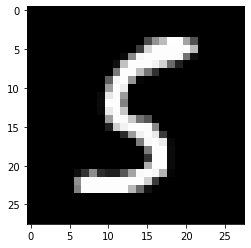

In [6]:
import matplotlib.pyplot as plt
def plot_image(img_index):
    # y_train contains the lables, ranging from 0 to 9
    # label_index = y_train_data[img_index]
    img = train_X[img_index].reshape(28, 28)
    plt.imshow(img, cmap = 'gray')
    # plt.imshow(train_X[img_index]/255, cmap = 'gray')
    # plt.title("Image %d: %s" %(img_index, dataset_labels[label_index]))
    
# Image index, you can pick any number between 0 and 59,999
img_index = 101
plot_image(img_index)


# Model

Let’s use the following network architecture:

- Two Relu-activated hidden layers, 
- Add dropout after the two hidden layers (to help the model generalize better),
- A softmax-activated output layer. 

The chain combinator is like `Sequential` in PyTorch or Keras: it combines a list of layers together with a feed-forward relationship.

Observe that when we **defined the model**, we don’t infor the input or the output sizes. This is inferred by the framework.


In [7]:
from thinc.api import chain, Relu, Softmax
 
n_hidden = 32
dropout = 0.2

model = chain(
    Relu(nO=n_hidden, dropout=dropout), 
    Relu(nO=n_hidden, dropout=dropout), 
    Softmax()
)

After creating the model, we can call the `Model.initialize` method, passing in a small batch of input data `X` and a small batch of output data `Y`. This allows Thinc to infer the missing dimensions.

NOTE!
We need, however, make sure the data is on the **right device** when passing in the data. This is done by calling `model.ops.asarray` which will e.g. transform the arrays to cupy when running on GPU.

In [8]:
# making sure the data is on the right device
train_X = model.ops.asarray(train_X)
train_Y = model.ops.asarray(train_Y)
test_X = model.ops.asarray(test_X)
test_Y = model.ops.asarray(test_Y)

model.initialize(X=train_X[:5], Y=train_Y[:5])
nI = model.get_dim("nI")
nO = model.get_dim("nO")
print(f"Initialized model with input dimension nI={nI} and output dimension nO={nO}")

Initialized model with input dimension nI=784 and output dimension nO=10


## Create an optimizer

Make several passes over the data, randomly selecting paired batches of the inputs and labels each time. While some machine learning libraries provide a single .fit() method to train a model all at once, Thinc puts you in charge of **shuffling and batching your data**, with the help of a few handy utility methods. model.ops.xp is an instance of either numpy or cupy, depending on whether you run the code on CPU or GPU.

You might argue if this is a advantage or drawback.

Let's wrap it in a training function.

In [9]:
def train_model(data, model, optimizer, n_iter, batch_size):
    (train_X, train_Y), (test_X, test_Y) = data
    indices = model.ops.xp.arange(train_X.shape[0], dtype="i")
    for i in range(n_iter):
        batches = model.ops.multibatch(batch_size, train_X, train_Y, shuffle=True)
        for X, Y in tqdm(batches, leave=False):
            Yh, backprop = model.begin_update(X)
            backprop(Yh - Y)
            model.finish_update(optimizer)
        # Evaluate and print progress
        correct = 0
        total = 0
        for X, Y in model.ops.multibatch(batch_size, test_X, test_Y):
            Yh = model.predict(X)
            correct += (Yh.argmax(axis=1) == Y.argmax(axis=1)).sum()
            total += Yh.shape[0]
        score = correct / total
        print(f" {i} {float(score):.3f}")

In [10]:
from thinc.api import Adam, fix_random_seed
from tqdm.notebook import tqdm

fix_random_seed(0)
optimizer = Adam(0.001)
batch_size = 128
print("Measuring performance across iterations:")

train_model(data, model, optimizer, 20, batch_size)


Measuring performance across iterations:


0 0.848


1 0.889


2 0.897


3 0.906


4 0.914


5 0.922


6 0.924


7 0.921


8 0.924


9 0.929


10 0.926


11 0.931


12 0.932


13 0.934


14 0.935


15 0.935


16 0.937


17 0.933


18 0.937


19 0.937


# Define the model based on configuration

Here's a config describing the model we defined above. The values in the `hyper_params` section can be referenced in other sections to keep them consistent. The `*` is used for **positional arguments** – in this case, the arguments to the `chain` function, two Relu layers and one softmax layer.

In [11]:
from thinc.api import Config, registry

CONFIG = """
[hyper_params]
n_hidden = 32
dropout = 0.2
learn_rate = 0.001

[model]
@layers = "chain.v1"

[model.*.relu1]
@layers = "Relu.v1"
nO = ${hyper_params:n_hidden}
dropout = ${hyper_params:dropout}

[model.*.relu2]
@layers = "Relu.v1"
nO = ${hyper_params:n_hidden}
dropout = ${hyper_params:dropout}

[model.*.softmax]
@layers = "Softmax.v1"

[optimizer]
@optimizers = "Adam.v1"
learn_rate = ${hyper_params:learn_rate}

[training]
n_iter = 10
batch_size = 128
"""

config = Config().from_str(CONFIG)
config

{'hyper_params': {'n_hidden': 32, 'dropout': 0.2, 'learn_rate': 0.001},
 'model': {'@layers': 'chain.v1',
  '*': {'relu1': {'@layers': 'Relu.v1', 'nO': 32, 'dropout': 0.2},
   'relu2': {'@layers': 'Relu.v1', 'nO': 32, 'dropout': 0.2},
   'softmax': {'@layers': 'Softmax.v1'}}},
 'optimizer': {'@optimizers': 'Adam.v1', 'learn_rate': 0.001},
 'training': {'n_iter': 10, 'batch_size': 128}}

When you call `registry.make_from_config`, Thinc will first create the three layers using the specified arguments populated by the hyperparameters. It will then pass the return values (the layer objects) to `chain`. It will also create an optimizer. All other values, like the training config, will be passed through as a regular dict. 

If you want to change a hyperparameter or experiment with a different optimizer, all you need to change is the config. For each experiment you run, you can save a config and you'll be able to reproduce it later.

Your training code can now look like this:

In [13]:
loaded_config = registry.make_from_config(config)

model = loaded_config["model"]
optimizer = loaded_config["optimizer"]
n_iter = loaded_config["training"]["n_iter"]
batch_size = loaded_config["training"]["batch_size"]

model.initialize(X=train_X[:5], Y=train_Y[:5])
train_model(data, model, optimizer, n_iter, batch_size)




0 0.847


1 0.878


2 0.892


3 0.909


4 0.911


5 0.911


6 0.921


7 0.922


8 0.925


9 0.925
